In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
# print('TensorFlow Version ' + tf.__version__)

In [15]:
# !pip install tensorflow-gpu==2.4.1

In [16]:
# pip install --force-reinstall --no-deps typing-extensions==4.4.0

In [3]:
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.11.0


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 7

TRAIN_PATH = '/kaggle/input/image-classification-pants/train'
TEST_PATH = '/kaggle/input/image-classification-pants/test'

DF_TRAIN = pd.read_csv('/kaggle/input/image-classification-pants/train.csv')
TEST_IMAGES = glob.glob(TEST_PATH + '/*.jpg')
DF_TEST = pd.DataFrame(TEST_IMAGES, columns = ['image_path'])

# Data Augmentations

In [5]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
    
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [6]:
DF_TRAIN['label'] = DF_TRAIN['label'].astype(str)

In [7]:
DF_TRAIN['label']

0        0
1        1
2        0
3        0
4        0
        ..
18386    1
18387    2
18388    1
18389    1
18390    1
Name: label, Length: 18391, dtype: object

# Data Generator

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = data_augment)

train_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        directory = TRAIN_PATH,
                                        x_col = 'file_name',
                                        y_col = 'label',
                                        subset = 'training',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = datagen.flow_from_dataframe(dataframe = DF_TRAIN,
                                        directory = TRAIN_PATH,
                                        x_col = 'file_name',
                                        y_col = 'label',
                                        subset = 'validation',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = datagen.flow_from_dataframe(dataframe = DF_TEST,
                                       x_col = 'image_path',
                                       y_col = None,
                                       batch_size = BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 14713 validated image filenames belonging to 7 classes.
Found 3678 validated image filenames belonging to 7 classes.
Found 5751 validated image filenames.


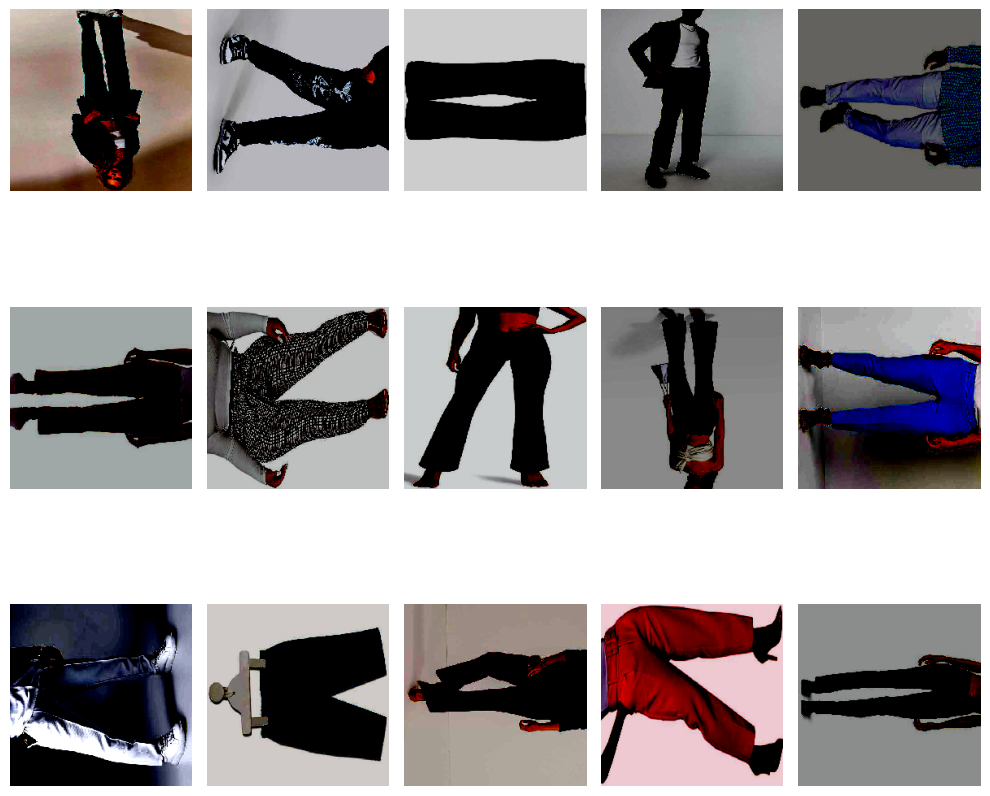

In [9]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

# Building the Model

In [10]:
!pip install --quiet vit-keras

from vit_keras import vit

## 1. ViT B32 Model

In [11]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

353253686/353253686 [==============================] - 2s 0us/step


### Visualizing Attention Maps of Sample Test Image

1/1 [==============================] - 13s 13s/step


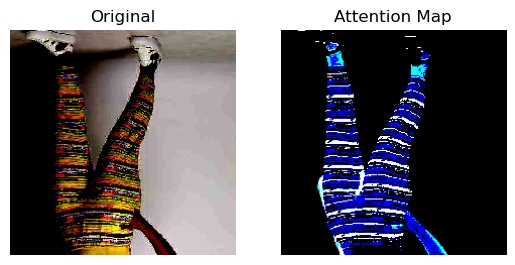

In [12]:
from vit_keras import visualize

x = test_gen.next()
image = x[0]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

## 2. Fine-tuning the Model

In [13]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(5, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 5)          

# Training the Model

In [14]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model.h5', save_weights_only = True)

Epoch 1/7


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 1041, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2976, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3258, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_24/2400438299.py", line 41, in <module>
      callbacks = callbacks)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1024, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1083, in compute_loss
      y, y_pred, sample_weight, regularization_losses=self.losses
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 284, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/losses.py", line 2005, in categorical_crossentropy
      y_true, y_pred, from_logits=from_logits, axis=axis
    File "/opt/conda/lib/python3.7/site-packages/keras/backend.py", line 5539, in categorical_crossentropy
      labels=target, logits=output, axis=axis
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[16,5] labels_size=[16,7]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_68579]

# Model Results

In [ ]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))